# Doppler winds#
Ivan Arias

2021/01/21

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import multidop
import pyart
import pydda
import tempfile
import os
import glob
import time

'/net/denali/storage2/radar2/people/idariash/home/CSU/RELAMPAGO/analysis/DualRadar/rsc/chivo.1a.20181214_020047.REL_PFAR360.nc'
filename_chivo = '/net/k2/storage/projects/RELAMPAGO/quality_controlled_data/level_1a/2018/12/14/chivo.1a.20181214_023049.REL_PNL360A.nc'
'/net/denali/storage2/radar2/people/idariash/home/CSU/RELAMPAGO/analysis/DualRadar/rsc/corcsapr2cfrppiM1.a1.20181214.020004.nc'
filename_csapr = '/net/k2/storage/projects/CSAPR/DOE_b1/corcsapr2cfrppiqcM1.b1.20181214.023003.nc'
'/net/denali/storage/radar/RELAMPAGO/RMA1/rma1_cfrad_20181214_02/cfrad.20181214_020345.000_to_20181214_020508.922_1_SUR.nc'
filename_rma = '/net/k2/storage/projects/RELAMPAGO/RMA1/rma1_cfrad_20181214_02/cfrad.20181214_022920.000_to_20181214_023043.922_1_SUR.nc'

r2 = pyart.io.read(filename_chivo)
r1 = pyart.io.read(filename_csapr)
r3 = pyart.io.read(filename_rma)

r2.azimuth['data'] = r2.azimuth['data'] + 45
r1.azimuth['data'] = r1.azimuth['data'] + 45
r3.azimuth['data'] = r3.azimuth['data'] + 45

# Rotate axis

r2.azimuth['data'] = (r2.azimuth['data'] + 45) % 360
r1.azimuth['data'] = (r1.azimuth['data'] + 45) % 360
r3.azimuth['data'] = (r3.azimuth['data'] + 45) % 360


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#%% Dealias velocity

# CHIVO r2
gatefilter = pyart.filters.GateFilter(r2)
gatefilter.exclude_transition()
gatefilter.exclude_invalid('reflectivity')
#gatefilter.exclude_invalid('differential_phase')
gatefilter.exclude_outside('reflectivity', 8, 100)
gatefilter.exclude_outside('cross_correlation_ratio', 0.5, 1)

nyq = r2.instrument_parameters['nyquist_velocity']['data'][0]

corr_vel = pyart.correct.dealias_region_based(
            r2, vel_field='velocity', keep_original=False, 
            gatefilter = gatefilter, nyquist_vel=nyq, centered = True)

r2.add_field('corrected_velocity', corr_vel, replace_existing = True)

# CSAPR r1
gatefilter = pyart.filters.GateFilter(r1)
gatefilter.exclude_transition()
gatefilter.exclude_invalid('mean_doppler_velocity')
gatefilter.exclude_invalid('reflectivity')
gatefilter.exclude_outside('reflectivity', 1.5, 100)
gatefilter.exclude_outside('normalized_coherent_power', 0.2, 1)
#gatefilter.exclude_outside('copol_correlation_coeff', 0.7, 1)

nyq = r1.instrument_parameters['nyquist_velocity']['data'][0]

corr_vel = pyart.correct.dealias_region_based(
            r1, vel_field='mean_doppler_velocity', keep_original=False, 
            gatefilter = gatefilter, nyquist_vel=nyq, centered = True)

r1.add_field('corrected_velocity', corr_vel, replace_existing = True)

# RMA-1 r3
gatefilter = pyart.filters.GateFilter(r3)
gatefilter.exclude_transition()
gatefilter.exclude_invalid('DBZH')
#gatefilter.exclude_invalid('differential_phase')
gatefilter.exclude_outside('DBZH', 8, 100)

nyq = np.amax(r3.fields['VRAD']['data'])

corr_vel = pyart.correct.dealias_region_based(
            r3, vel_field='VRAD', keep_original=False, 
            gatefilter = gatefilter, nyquist_vel=nyq, centered = True)

r3.add_field('corrected_velocity', corr_vel, replace_existing = True)

In [3]:
cp = deepcopy(r1.fields['reflectivity']['data'])
r1.add_field_like('reflectivity', 'DT', cp, replace_existing=True)
cp = deepcopy(r1.fields['corrected_velocity']['data'])
r1.add_field_like('corrected_velocity', 'VT', cp, replace_existing=True)

cp = deepcopy(r2.fields['reflectivity']['data'])
r2.add_field_like('reflectivity', 'DT', cp, replace_existing=True)
cp = deepcopy(r2.fields['corrected_velocity']['data'])
r2.add_field_like('corrected_velocity', 'VT', cp, replace_existing=True)

cp = deepcopy(r3.fields['DBZH']['data'])
r3.add_field_like('DBZH', 'DT', cp, replace_existing=True)
cp = deepcopy(r3.fields['corrected_velocity']['data'])
r3.add_field_like('corrected_velocity', 'VT', cp, replace_existing=True)

#%%
# The analysis engine currently expects the "missing_value" attribute
r1.fields['DT']['missing_value'] = 1.0 * r1.fields['DT']['_FillValue']
r2.fields['DT']['missing_value'] = 1.0 * r2.fields['DT']['_FillValue']
r3.fields['DT']['missing_value'] = 1.0 * r3.fields['DT']['_FillValue']
r1.fields['VT']['missing_value'] = 1.0 * r1.fields['VT']['_FillValue']
r2.fields['VT']['missing_value'] = 1.0 * r2.fields['VT']['_FillValue']
r3.fields['VT']['missing_value'] = 1.0 * r3.fields['VT']['_FillValue']

#%% Now grid the volumes and add azimuths and elevations afterward
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000),
               fields=['DT', 'VT'], origin=None):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        gridding_algo='map_gates_to_grid', grid_origin_alt=0.0)
    print(time.time()-bt, 'seconds to grid radar')
    return grid

#%%
# Fix for Py-ART problem with r2's data structure
# This can be skipped if you don't have TypeErrors while gridding
r2.longitude['data'] = np.array([r2.longitude['data'][0]])
r2.altitude['data'] = np.array([r2.altitude['data'][0]])
r2.latitude['data'] = np.array([r2.latitude['data'][0]])

#%%
g1 = grid_radar(r1, origin=(r2.latitude['data'][0], r2.longitude['data'][0]),
                xlim=(-100000, 50000), ylim=(-100000, 50000), grid_shape=(20, 151, 151))
g2 = grid_radar(r2, origin=(r2.latitude['data'][0], r2.longitude['data'][0]),
                xlim=(-100000, 50000), ylim=(-100000, 50000), grid_shape=(20, 151, 151))
g3 = grid_radar(r3, origin=(r2.latitude['data'][0], r2.longitude['data'][0]),
                xlim=(-100000, 50000), ylim=(-100000, 50000), grid_shape=(20, 151, 151))

# Set initialization and do retrieval
u_init, v_init, w_init = pydda.initialization.make_constant_wind_field(g1, vel_field='VT')
new_grids = pydda.retrieval.get_dd_wind_field([g1, g2, g3],
                                              u_init, v_init, w_init,
                                              vel_name='VT', refl_field='DT',
                                              mask_outside_opt=True)

/top/students/GRAD/ECE/idariash/home/anaconda3/lib/python3.7/site-packages/pyart/map/gates_to_grid.py:162: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


5.351729869842529 seconds to grid radar


/top/students/GRAD/ECE/idariash/home/anaconda3/lib/python3.7/site-packages/pyart/map/gates_to_grid.py:162: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


5.806000471115112 seconds to grid radar


/top/students/GRAD/ECE/idariash/home/anaconda3/lib/python3.7/site-packages/pyart/map/gates_to_grid.py:162: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


0.8659141063690186 seconds to grid radar


/top/students/GRAD/ECE/idariash/home/anaconda3/lib/python3.7/site-packages/pydda/retrieval/angles.py:24: RuntimeWarning: invalid value encountered in arccos
  elev = np.arccos((Re**2 + slantrsq - rh**2)/(2 * Re * slantr))


Calculating weights for radars 0 and 1
Calculating weights for radars 0 and 2
Calculating weights for radars 1 and 2
Calculating weights for models...
Starting solver 
rmsVR = 20.39357456842052
Total points: 409162


/top/students/GRAD/ECE/idariash/home/anaconda3/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: divide by zero encountered in true_divide
  theta_2 = np.arccos((x-rad2[1])/b)
/top/students/GRAD/ECE/idariash/home/anaconda3/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:653: RuntimeWarning: invalid value encountered in arccos
  theta_2 = np.arccos((x-rad2[1])/b)
/top/students/GRAD/ECE/idariash/home/anaconda3/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:654: RuntimeWarning: invalid value encountered in true_divide
  return np.arccos((a*a+b*b-c*c)/(2*a*b))
/top/students/GRAD/ECE/idariash/home/anaconda3/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:408: RuntimeWarning: invalid value encountered in greater_equal
  bca[i, j] >= math.radians(min_bca),
/top/students/GRAD/ECE/idariash/home/anaconda3/lib/python3.7/site-packages/pydda/retrieval/wind_retrieve.py:409: RuntimeWarning: invalid value encountered in less_equal

| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|2315.7618|1045.2155|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  94.5722
Norm of gradient: 0.21908447864447206
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|1903.4293| 800.2422|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000| 100.0000
Norm of gradient: 0.14625867765651274
Iterations before filter: 20
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|1757.7289| 682.1670|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000| 100.0000
Norm of gradient: 0.09375870720419346
Iterations before filter: 30
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
|1709.7861| 612.3121|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000| 100.0000
Norm of gradient: 0.14042052956009085
Iterations before filter: 40
Applying low pass filter to wind field...
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvor

In [4]:
fname = 'DDA_3radars_rotated_20181214_0230.nc'

pyart.io.write_grid(fname, new_grids[0])

Text(0, 0.5, 'Distance north of CHIVO (km)')

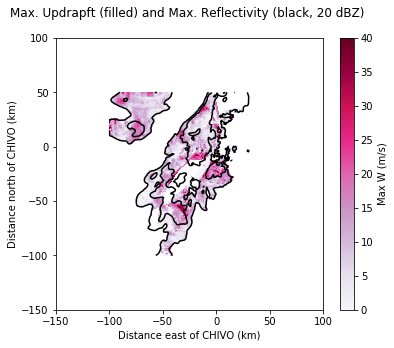

In [6]:
# Here start the plots
fig = plt.figure(figsize=(6, 5))

DZcomp = np.amax(new_grids[1].fields['DT']['data'], axis=0)
x, y = np.meshgrid(0.001*new_grids[0].x['data'], 0.001*new_grids[1].y['data'])
#DZcomp = spyi.gaussian_filter(DZcomp, sigma = 0.5)
#DZcomp = np.ma.masked_where( DZcomp_original < 20, DZcomp_original)
# Smooth out and mask

Wcomp = np.amax(new_grids[0].fields['w']['data'], axis=0)
#Wcomp = np.ma.masked_where( Wcomp < 3, Wcomp)
Wcomp = np.ma.masked_where( DZcomp < 20, Wcomp)
#Wcomp = np.ma.masked_where( x > -30 , Wcomp)
#Wcomp = np.ma.masked_where( y < -37 , Wcomp)

cs = plt.pcolormesh(0.001*new_grids[0].x['data'], 0.001*new_grids[0].y['data'],
                    Wcomp, vmin=0, vmax=40, cmap='PuRd')
contours_DZcomp = plt.contour(x, y, DZcomp, levels=[20,40,60], colors=['k', 'k', 'k'])
#plt.clabel(contours_DZcomp, [25,50], fmt='%r', inline=True, fontsize = 10)

plt.xlim(-150, 100)
plt.ylim(-150, 100)
plt.colorbar(cs, label='Max W (m/s)')


plt.title('Max. Updrapft (filled) and Max. Reflectivity (black, 20 dBZ) \n')
plt.xlabel('Distance east of CHIVO (km)')
plt.ylabel('Distance north of CHIVO (km)')

<function matplotlib.pyplot.show(*args, **kw)>

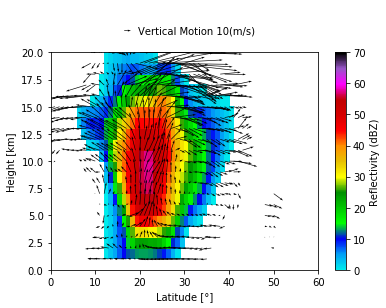

In [48]:
from mpl_toolkits.basemap import cm
lwys = cm.GMT_wysiwyg

ind = 151 - 50 - 75
#ind = 100 +16
thin = 1

U = new_grids[0].fields['u']['data']
V = new_grids[0].fields['v']['data']
W = new_grids[0].fields['w']['data']
Z = new_grids[0].fields['DT']['data']
y, z = np.meshgrid(0.001*new_grids[0].y['data'], 0.001*new_grids[0].z['data'])

V = np.swapaxes(V,1,2)
W= np.swapaxes(W,1,2)
Z = np.swapaxes(Z,1,2)

V = np.swapaxes(V,0,1)
W= np.swapaxes(W,0,1)
Z = np.swapaxes(Z,0,1)

# substract U anomalies from each layer


V_anomalies = new_grids[0].fields['v']['data']

for i in range(len(V_anomalies)):
    Vm = np.ma.median(V_anomalies[i])
    V_anomalies[i] = V_anomalies[i] - Vm
    
V_anomalies = np.swapaxes(V_anomalies,0,1)

Z = np.ma.masked_where( Z < 0 , Z)

chivo_lons, chivo_lats = new_grids[0].get_point_longitude_latitude()
lats_vector = np.mean(chivo_lats, axis=1)
lats_mat, z = np.meshgrid(lats_vector, 0.001*new_grids[0].z['data'])

#fig = plt.figure(figsize=(7, 3))
cs = plt.pcolormesh(y, z, #lats_vector,
                    Z[ind], vmin=0, vmax=70, cmap='pyart_NWSRef')

ilev = ind



#U[ilev] = np.ma.masked_where( z > 14 , U[ilev])
#U[ilev] = np.ma.masked_where( x > -20 , U[ilev])

                #lats_mat[::thin, ::thin]
q = plt.quiver(y[::thin, ::thin], z[::thin, ::thin], 
            V[ilev][::thin, ::thin], W[ilev][::thin, ::thin],
            scale = 400, color='black',)

plt.quiverkey(q, X=0.3, Y=1.1, U=10,
             label='Vertical Motion 10(m/s)', labelpos='E')

plt.xlim(0, 60)
plt.ylim(0, 20)

# plt.xlim(-54, -36)
# plt.ylim(-18, 0)

plt.colorbar(cs, label='Reflectivity (dBZ)')
#plt.title('Max Reflectivity (filled) and Updrafts (black, 10 m/s)\n \n' )
plt.title('\n \n')
plt.xlabel('Latitude [°]')
plt.ylabel('Height [km]')

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

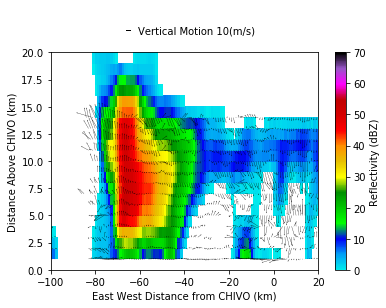

In [43]:
from mpl_toolkits.basemap import cm
lwys = cm.GMT_wysiwyg

ind = 151 - 50 + 13
thin = 1

U = new_grids[0].fields['u']['data']
V = new_grids[0].fields['v']['data']
W = new_grids[0].fields['w']['data']
Z = new_grids[0].fields['DT']['data']
x, z = np.meshgrid(0.001*new_grids[1].x['data'], 0.001*new_grids[1].z['data'])


U = np.swapaxes(U,0,1)
W= np.swapaxes(W,0,1)
Z = np.swapaxes(Z,0,1)



# substract U anomalies from each layer

#ind = 151 - 50 - 15
thin = 1

U_anomalies = new_grids[0].fields['u']['data']

for i in range(len(U_anomalies)):
    Um = np.ma.median(U_anomalies[i])
    U_anomalies[i] = U_anomalies[i] - Um
    
U_anomalies = np.swapaxes(U_anomalies,0,1)

#ind = 151 - 50 - 15
thin = 1

Z = np.ma.masked_where( Z < 0 , Z)

cs = plt.pcolormesh(0.001*new_grids[1].x['data'], 0.001*new_grids[1].z['data'],
                    Z[ind], vmin=0, vmax=70, cmap='pyart_NWSRef')

ilev = ind



U[ilev] = np.ma.masked_where( z > 14 , U[ilev])
#U[ilev] = np.ma.masked_where( x > -20 , U[ilev])

q = plt.quiver(x[::thin, ::thin], z[::thin, ::thin],
            U[ilev][::thin, ::thin], W[ilev][::thin, ::thin],
            units = 'xy', angles='xy', scale = 6, zorder=10, color='black',
            width=0.1, headwidth=3., headlength=4.)

plt.quiverkey(q, X=0.3, Y=1.1, U=10,
             label='Vertical Motion 10(m/s)', labelpos='E')

plt.xlim(-100, 20)
plt.ylim(0, 20)

# plt.xlim(-54, -36)
# plt.ylim(-18, 0)

plt.colorbar(cs, label='Reflectivity (dBZ)')
#plt.title('Max Reflectivity (filled) and Updrafts (black, 10 m/s)\n \n' )
plt.title('\n \n')
plt.xlabel('East West Distance from CHIVO (km)')
plt.ylabel('Distance Above CHIVO (km)')

plt.show